<a href="https://colab.research.google.com/github/reiinakano/adversarially-robust-neural-style-transfer/blob/master/Robust_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer with Adversarially Robust Classifiers

This is an accompanying notebook for the blog post https://reiinakano.com/2019/06/15/robust-neural-style-transfer.html


# Download dependencies

In [1]:
!git clone https://github.com/MadryLab/robustness_lib.git /home/robustness_lib
!wget https://s3-us-west-2.amazonaws.com/andrewilyas.com/RestrictedImageNet.pt -O /home/RestrictedImageNet.pt

Cloning into '/home/robustness_lib'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 38 (delta 1), reused 38 (delta 1), pack-reused 0
Unpacking objects: 100% (38/38), done.
--2019-06-23 09:39:38--  https://s3-us-west-2.amazonaws.com/andrewilyas.com/RestrictedImageNet.pt
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.252.168
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.252.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188569381 (180M) [binary/octet-stream]
Saving to: ‘/home/RestrictedImageNet.pt’

/home/RestrictedIma 100%[===================>] 179.83M  47.1MB/s    in 4.0s    

2019-06-23 09:39:42 (45.0 MB/s) - ‘/home/RestrictedImageNet.pt’ saved [188569381/188569381]



In [0]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
!wget https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg
!wget https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/the_scream.jpg
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/escher_sphere.jpg
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/woman-with-hat-matisse.jpg
!wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/tubingen.jpg
!wget https://images.academics.com/working-in-tuebingen.jpg

--2019-06-22 03:02:42--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.002s  

2019-06-22 03:02:43 (49.2 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2019-06-22 03:02:46--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.001s  

2019-06-22 03:02:46 (54.6 MB/s) - ‘dancing.jpg’ saved [40484/40484]

--2019-06-22 03:02:48--  https://storage

In [0]:

import sys
sys.path.append('/home/robustness_lib')
import os
import io
from PIL import Image
import torchvision.transforms.functional as F
import torchvision.models as models
import torch as ch
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.model_zoo as model_zoo


import json
from robustness import datasets, model_utils, constants, helpers
from torchvision import transforms
import traceback
import io
import torch.nn as nn

import copy

import matplotlib.pyplot as plt
import time

In [0]:
device = ch.device("cuda" if ch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if ch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)[:, :3, :, :]
    return image.to(device, ch.float)


style_img = image_loader("./starry-night.png")
#style_img = image_loader("./picasso.jpg")
content_img = image_loader("./notebook-styletransfer-bigben.jpg")


In [0]:
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image

    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [0]:
dataset = datasets.RestrictedImageNet('')

In [0]:
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': '/home/RestrictedImageNet.pt',
    'state_dict_path': 'model',
    'parallel': False
}

In [0]:
model, ckpt = model_utils.make_and_restore_model(**model_kwargs)
robust_resnet = model.model

reg_resnet = copy.deepcopy(robust_resnet)
new_params = reg_resnet.state_dict()
partial_params = model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')
del partial_params['fc.bias']
del partial_params['fc.weight']
new_params.update(partial_params)
reg_resnet.load_state_dict(new_params)

vgg = models.vgg19(pretrained=True).features

=> loading checkpoint '/home/RestrictedImageNet.pt'
=> loaded checkpoint '/home/RestrictedImageNet.pt' (epoch 61)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 136600301.31it/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:18<00:00, 30354105.94it/s]


In [0]:
class ContentLoss(nn.Module):

    def __init__(self, feature_maps,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.feature_maps = {key: val.detach() for key, val in feature_maps.items()}

    def forward(self, input, layer_name):
        return functional.mse_loss(input[layer_name], self.feature_maps[layer_name])

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = ch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
  
class StyleLoss(nn.Module):

    def __init__(self, feature_maps):
        super(StyleLoss, self).__init__()
        self.feature_maps = {key: gram_matrix(val).detach() for key, val in feature_maps.items()}

    def forward(self, input, layer_name):
        G = gram_matrix(input[layer_name])
        return functional.mse_loss(G, self.feature_maps[layer_name])
      
class StyleTransferModel(nn.Module):
  def __init__(self, model, mean, std):
    super(StyleTransferModel, self).__init__()
    self.normalize = helpers.InputNormalize(mean, std)
    self.model = model  # Resnet50 model
   
  def forward(self, x):
    layers = {}
    
    x = self.normalize(x)
    
    x = self.model.conv1(x)
    x = self.model.bn1(x)
    x = self.model.relu(x)
    x = self.model.maxpool(x)
    
    x = self.model.layer1(x)
    layers['conv_1'] = x
    x = self.model.layer2(x)
    layers['conv_2'] = x
    x = self.model.layer3(x)
    layers['conv_3'] = x
    x = self.model.layer4(x, fake_relu=True)
    layers['conv_4'] = x
    
    return layers

class VGGStyleTransferModel(nn.Module):
  def __init__(self, model, mean, std):
    super(VGGStyleTransferModel, self).__init__()
    self.normalize = helpers.InputNormalize(mean, std)
    self.model = model  # VGG model

  def forward(self, x):
    layers = {}
    
    x = self.normalize(x)
    
    i=0
    for layer in self.model.children():
      if isinstance(layer, nn.Conv2d):
          i += 1
          name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
          name = 'relu_{}'.format(i)
          # The in-place version doesn't play very nicely with the ContentLoss
          # and StyleLoss we insert below. So we replace with out-of-place
          # ones here.
          layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
          name = 'pool_{}'.format(i)
          layer = nn.AvgPool2d(kernel_size=2, stride=2)
      elif isinstance(layer, nn.BatchNorm2d):
          name = 'bn_{}'.format(i)
      else:
          raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      x = layer(x)
      
      if isinstance(layer, nn.Conv2d):
        layers[name] = x
      if i == 13:  # This is the last layer we usually use for style transfer
        break
    return layers


In [0]:
def get_input_optimizer(input_img, opt='Adam'):
    # this line to show that input is a parameter that requires a gradient
    if opt == 'Adam':
      optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)
    elif opt == 'LBFGS':
      optimizer = optim.LBFGS([input_img.requires_grad_()])
    else:
      raise RuntimeError('Unrecognized optimizer: {}'.format(opt))
    return optimizer

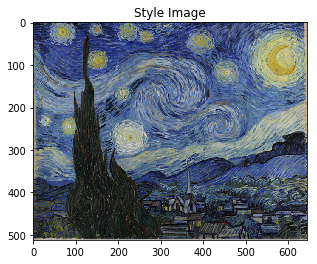

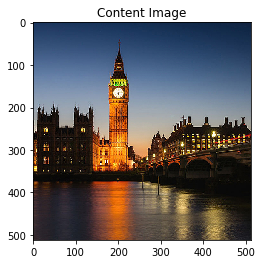

In [0]:


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
def style_transfer(st_model, content_img, style_img, start_from_content=True,
                   n_iters=[0, 2000], style_weight=1e9, content_weight=1,
                   content_layers=['conv_3'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4'],
                   opt='Adam',
                   verbose=True,
                   ):
  st_model.eval().cuda()
  
  if isinstance(content_img, str):
    content_img = image_loader(content_img)
  
  if isinstance(style_img, str):
    style_img = image_loader(style_img)
  
  content_feature_maps = st_model(content_img)
  content_feature_maps = {key: val.detach() for key, val in content_feature_maps.items()}
  
  style_feature_maps = st_model(style_img)
  style_feature_maps = {key: val.detach() for key, val in style_feature_maps.items()}
  
  content_loss_func = ContentLoss(content_feature_maps)
  style_loss_func = StyleLoss(style_feature_maps)
  
  if start_from_content:
    input_img = content_img.clone()
  else:
    input_img = ch.randn(content_img.data.size(), device=device)
    
  optimizer = get_input_optimizer(input_img, opt=opt)
  
  images = []
  run = [0]
  start_time = time.time()
  while run[0] <= n_iters[-1]:
    def closure():
      # correct the values of updated input image
      input_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      input_feature_maps = st_model(input_img)
      
      style_score = 0
      content_score = 0
      

      for sl in style_layers:
          _l = style_loss_func(input_feature_maps, sl) * style_weight
          style_score += _l
          #print(_l)
      for cl in content_layers:
          content_score += content_loss_func(input_feature_maps, cl) * content_weight
          #print(content_score)

      #style_score *= style_weight
      #content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      if run[0] in n_iters:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f} time elapsed: {} seconds'.format(
              style_score.item(), content_score.item(), time.time() - start_time))
          if verbose:
            plt.figure(figsize=(8, 8))
            imshow(input_img, title='run {}:'.format(run))
            
          unloader = transforms.ToPILImage()  # reconvert into PIL image
          image = input_img.clone().cpu()  # we clone the tensor to not do changes on it
          image = image.squeeze(0)      # remove the fake batch dimension
          image = unloader(image)
          images.append(image)

      run[0] += 1

      return style_score + content_score

    optimizer.step(closure)

  # a last correction...
  input_img.data.clamp_(0, 1)

  return input_img, images

run [0]:
Style Loss : 2099639680.000000 Content Loss: 0.000000 time elapsed: 0.1593475341796875 seconds


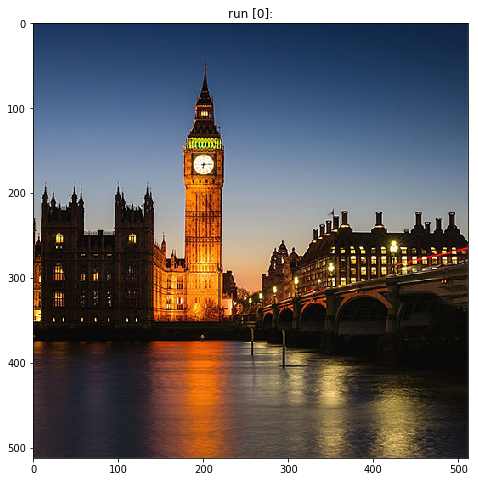

run [100]:
Style Loss : 303722112.000000 Content Loss: 0.009008 time elapsed: 8.889360904693604 seconds


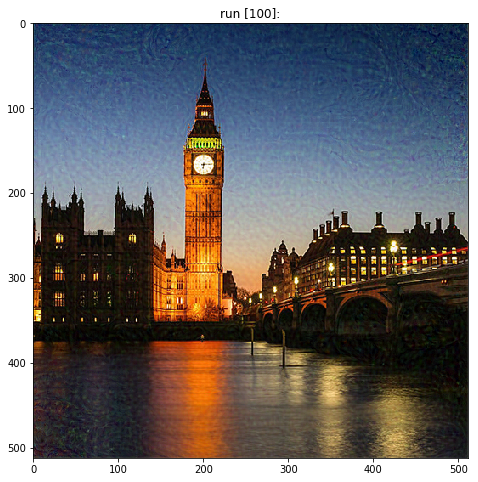

run [200]:
Style Loss : 178341696.000000 Content Loss: 0.010770 time elapsed: 19.435412645339966 seconds


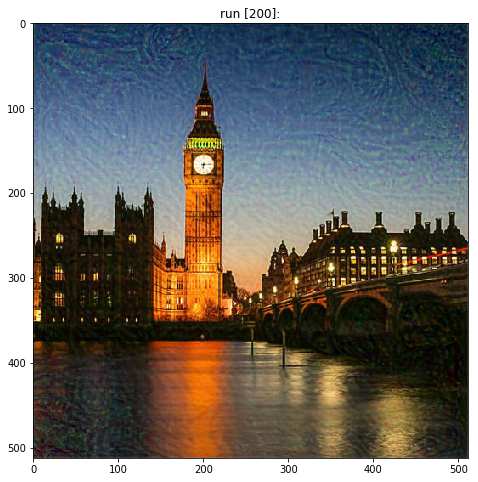

run [300]:
Style Loss : 113901344.000000 Content Loss: 0.011813 time elapsed: 30.001496076583862 seconds


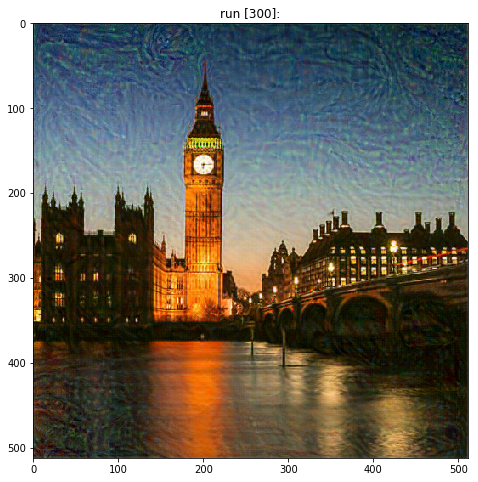

run [400]:
Style Loss : 74148680.000000 Content Loss: 0.012526 time elapsed: 40.458836793899536 seconds


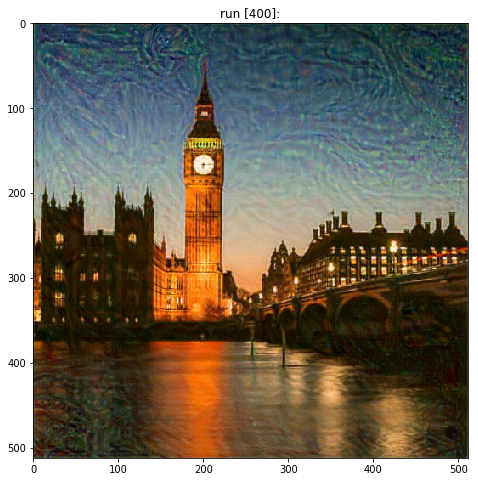

In [0]:
out = style_transfer(
    StyleTransferModel(reg_resnet, dataset.mean, dataset.std), 
    'notebook-styletransfer-bigben.jpg', 'the_scream.jpg', style_weight=1e17, content_weight=1,
    start_from_content=True, n_iters=range(0, 500, 100), opt='LBFGS')


run [0]:
Style Loss : 2.357913 Content Loss: 0.000000 time elapsed: 0.08845639228820801 seconds


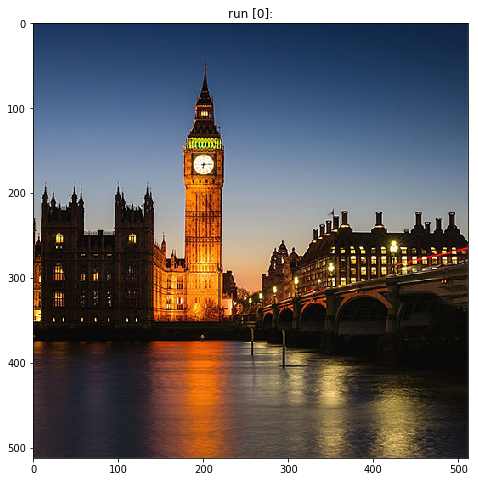

run [100]:
Style Loss : 0.003617 Content Loss: 0.010127 time elapsed: 8.802317380905151 seconds


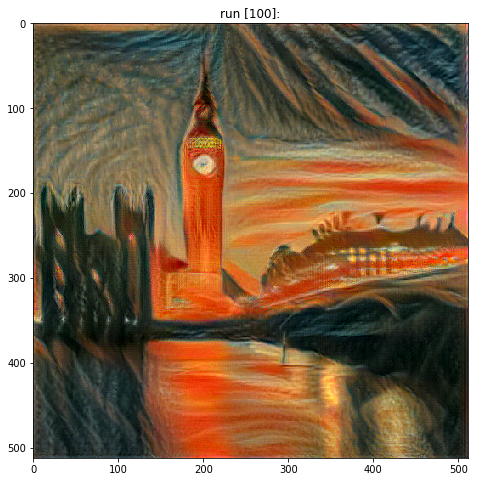

run [200]:
Style Loss : 0.002981 Content Loss: 0.009601 time elapsed: 19.22215461730957 seconds


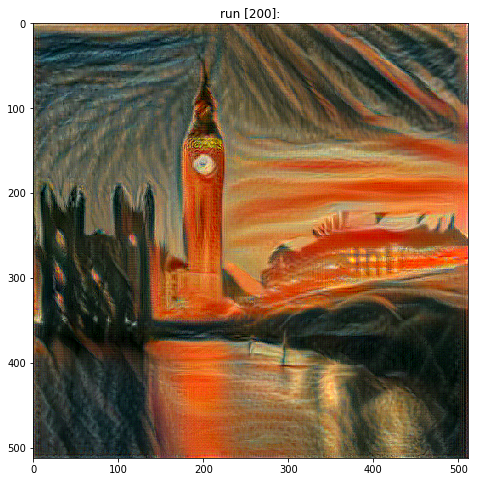

run [300]:
Style Loss : 0.002889 Content Loss: 0.009403 time elapsed: 29.59492301940918 seconds


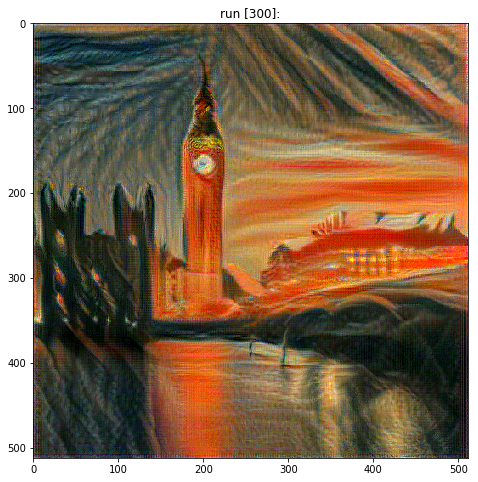

run [400]:
Style Loss : 0.002857 Content Loss: 0.009357 time elapsed: 39.94545793533325 seconds


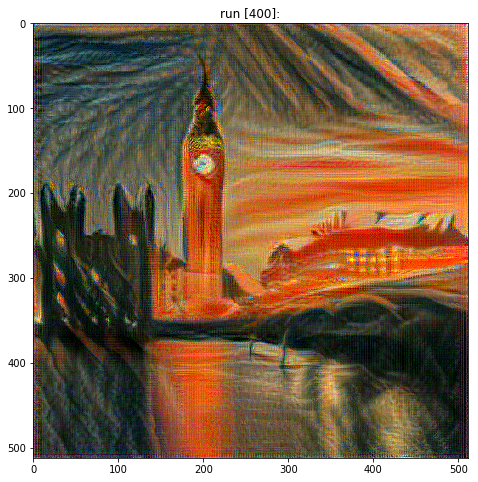

In [0]:
out = style_transfer(
    StyleTransferModel(robust_resnet, dataset.mean, dataset.std), 
    'notebook-styletransfer-bigben.jpg', 'the_scream.jpg', style_weight=1e9, content_weight=1,
    start_from_content=True, n_iters=range(0, 500, 100), opt='LBFGS')


run [0]:
Style Loss : 1325.859863 Content Loss: 0.000000 time elapsed: 0.2561807632446289 seconds


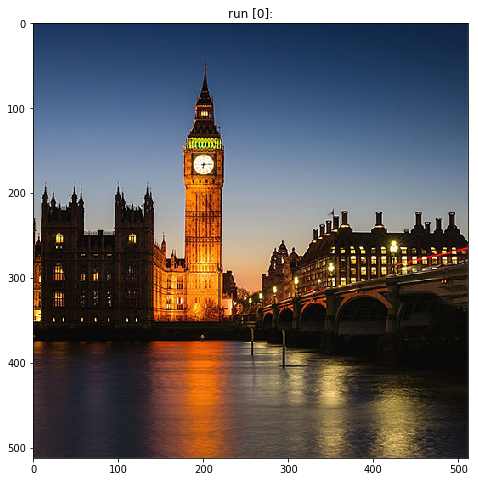

run [100]:
Style Loss : 1.543256 Content Loss: 4.210505 time elapsed: 14.135109663009644 seconds


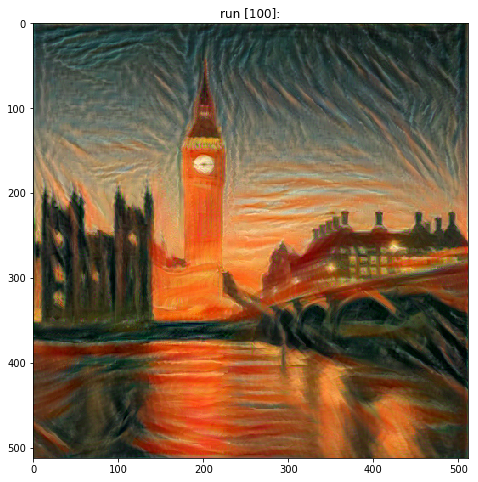

run [200]:
Style Loss : 0.841403 Content Loss: 3.606951 time elapsed: 29.964105367660522 seconds


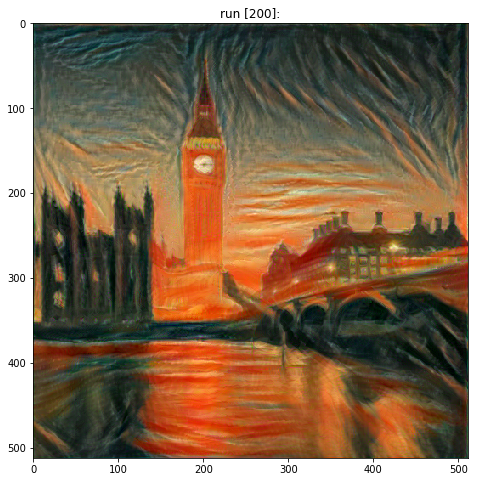

run [300]:
Style Loss : 0.748316 Content Loss: 3.397102 time elapsed: 45.6778507232666 seconds


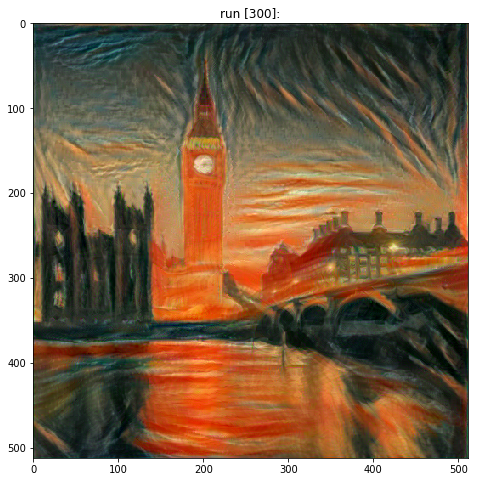

run [400]:
Style Loss : 0.711450 Content Loss: 3.288724 time elapsed: 61.23555374145508 seconds


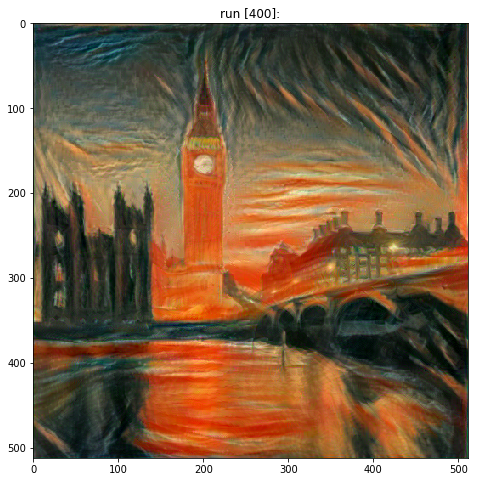

In [0]:
out = style_transfer(
    VGGStyleTransferModel(vgg, dataset.mean, dataset.std), 
    'notebook-styletransfer-bigben.jpg', 'the_scream.jpg', style_weight=4e6, content_weight=1,
    start_from_content=True, n_iters=range(0, 500, 100), content_layers=['conv_10'],
    style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13'], opt='LBFGS')


# Grid search

In [0]:
import json
import glob

def create_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
#!rm -r outputs_images


In [0]:
def search_robust():
  base_output_directory = 'outputs_images/'
  style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  content_layers = ['conv_3']
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_weights = [1e11, 1e10, 1e9, 1e8]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', 'starry-night.png', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['notebook-styletransfer-bigben.jpg', 'dancing.jpg', 'tubingen.jpg', 'working-in-tuebingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
            for r in ['r']:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}_{}'.format(sfc, sw, cw, r)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                StyleTransferModel(robust_resnet if r == 'r' else reg_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_robust()

starting outputs_images/si_the_scream.jpg__ci_working-in-tuebingen.jpg sfcTrue_sw100000000000.0_cw1_r
run [0]:
Style Loss : 517.008789 Content Loss: 0.000000 time elapsed: 0.1522510051727295 seconds
run [50]:
Style Loss : 0.260509 Content Loss: 0.014751 time elapsed: 5.271109104156494 seconds
run [100]:
Style Loss : 0.110486 Content Loss: 0.016419 time elapsed: 11.44731855392456 seconds
run [200]:
Style Loss : 0.048427 Content Loss: 0.017607 time elapsed: 24.9620418548584 seconds
run [300]:
Style Loss : 0.033609 Content Loss: 0.017996 time elapsed: 38.51835060119629 seconds
run [400]:
Style Loss : 0.027847 Content Loss: 0.018127 time elapsed: 52.152846336364746 seconds
run [500]:
Style Loss : 0.025002 Content Loss: 0.018157 time elapsed: 65.84444189071655 seconds
starting outputs_images/si_the_scream.jpg__ci_working-in-tuebingen.jpg sfcFalse_sw100000000000.0_cw1_r
run [0]:
Style Loss : 6045.245605 Content Loss: 0.025540 time elapsed: 0.09877920150756836 seconds
run [50]:
Style Loss : 0

In [0]:
!zip -rq outputs_images.zip outputs_images

In [0]:
import glob

def search_nonrobust():
  base_output_directory = 'outputs_images_nonrobust/'
  style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  content_layers = ['conv_3']
  iters = [0, 50, 100, 200, 500]
  style_weights = [1e14]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', 'starry-night.png', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['notebook-styletransfer-bigben.jpg', 'dancing.jpg', 'tubingen.jpg', 'working-in-tuebingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
            for r in ['nr']:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}_{}'.format(sfc, sw, cw, r)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                StyleTransferModel(robust_resnet if r == 'r' else reg_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_nonrobust()

starting outputs_images_nonrobust/si_the_scream.jpg__ci_working-in-tuebingen.jpg sfcTrue_sw100000000000000.0_cw1_nr
run [0]:
Style Loss : 1827906.750000 Content Loss: 0.000000 time elapsed: 0.22657465934753418 seconds
run [50]:
Style Loss : 495377.000000 Content Loss: 0.006317 time elapsed: 5.3800880908966064 seconds
run [100]:
Style Loss : 330067.312500 Content Loss: 0.008251 time elapsed: 11.618748188018799 seconds
run [200]:
Style Loss : 183178.906250 Content Loss: 0.010453 time elapsed: 25.266204833984375 seconds
run [500]:
Style Loss : 49135.242188 Content Loss: 0.012701 time elapsed: 66.5153067111969 seconds
starting outputs_images_nonrobust/si_the_scream.jpg__ci_working-in-tuebingen.jpg sfcFalse_sw100000000000000.0_cw1_nr
run [0]:
Style Loss : 45051592.000000 Content Loss: 0.018952 time elapsed: 0.12586712837219238 seconds
run [50]:
Style Loss : 838183.250000 Content Loss: 0.016282 time elapsed: 5.431889295578003 seconds
run [100]:
Style Loss : 444330.093750 Content Loss: 0.0168

In [0]:
!zip -rq outputs_images_nonrobust.zip outputs_images_nonrobust


In [0]:
import glob

def search_vgg():
  base_output_directory = 'outputs_images_vgg/'
  style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
  content_layers = ['conv_10']
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_weights = [1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4]
  content_weights = [1]
  start_from_contents = [True, False]
  style_images = ['the_scream.jpg', 'starry-night.png', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']
  content_images = ['notebook-styletransfer-bigben.jpg', 'dancing.jpg', 'tubingen.jpg']

  for style_img in style_images:
    for content_img in content_images:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
              out_dir = os.path.join(
                  base_output_directory, 
                  'si_{}__ci_{}'.format(style_img, content_img),
                  )
              create_dir(out_dir)
              fn = 'sfc{}_sw{}_cw{}'.format(sfc, sw, cw)
              existing = glob.glob(os.path.join(out_dir, fn+'_*'))
              if existing:
                print('found {}, skipping', existing[0])
                continue
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                VGGStyleTransferModel(vgg, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=content_layers, style_layers=style_layers, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_vgg()

starting outputs_images_vgg/si_the_scream.jpg__ci_notebook-styletransfer-bigben.jpg sfcTrue_sw10000000000.0_cw1
run [0]:
Style Loss : 3314649.500000 Content Loss: 0.000000
run [50]:
Style Loss : 9932.717773 Content Loss: 8.339229
run [100]:
Style Loss : 2199.474854 Content Loss: 8.632983
run [200]:
Style Loss : 394.453735 Content Loss: 8.851016
run [300]:
Style Loss : 188.241592 Content Loss: 8.967195
run [400]:
Style Loss : 118.429131 Content Loss: 9.065153
run [500]:
Style Loss : 86.199432 Content Loss: 9.130035
starting outputs_images_vgg/si_the_scream.jpg__ci_notebook-styletransfer-bigben.jpg sfcFalse_sw10000000000.0_cw1
run [0]:
Style Loss : 636637824.000000 Content Loss: 8.791380
run [50]:
Style Loss : 78508.468750 Content Loss: 10.969963
run [100]:
Style Loss : 18952.615234 Content Loss: 10.889499
run [200]:
Style Loss : 1671.606934 Content Loss: 10.706470
run [300]:
Style Loss : 458.786499 Content Loss: 10.686253
run [400]:
Style Loss : 223.910065 Content Loss: 10.678801
run [5

In [0]:
!zip -rq outputs_images_vgg.zip outputs_images_vgg


In [0]:
#!rm -r outputs_textures
def search_textures():
  base_output_directory = 'outputs_textures/'
  
  vgg_style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
  vgg_content_layers = ['conv_10']

  resnet_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
  resnet_content_layers = ['conv_3']
  
  style_weight = 1e9
  
  iters = [0, 50, 100, 200, 300, 400, 500]
  style_images = ['the_scream.jpg', 'starry-night.png', 'picasso.jpg', 
                  'escher_sphere.jpg', 'woman-with-hat-matisse.jpg']

  for style_img in style_images:
    for clf in ['r', 'nr', 'vgg']:
      out_dir = base_output_directory
      create_dir(out_dir)
      fn = '{}_{}_texture'.format(clf, style_img)
      existing = glob.glob(os.path.join(out_dir, fn+'_*'))
      if existing:
        print('found {}, skipping', existing[0])
        continue
      print('starting', out_dir, fn)
      if clf == 'vgg':
        model = VGGStyleTransferModel(vgg, dataset.mean, dataset.std)
      else:
        model = StyleTransferModel(robust_resnet if clf == 'r' else reg_resnet, dataset.mean, dataset.std)
      _, outs = style_transfer(
        model, 
        'dancing.jpg', style_img, start_from_content=False, n_iters=iters, style_weight=style_weight, 
        content_weight=0,
        content_layers=vgg_content_layers if clf == 'vgg' else resnet_content_layers, 
        style_layers=vgg_style_layers if clf == 'vgg' else resnet_style_layers,
        opt='LBFGS', verbose=False)
      for im, i in zip(outs, iters):
        im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search_textures()

starting outputs_textures/ r_the_scream.jpg_texture
run [0]:
Style Loss : 60.392670 Content Loss: 0.000000
run [50]:
Style Loss : 0.007348 Content Loss: 0.000000
run [100]:
Style Loss : 0.002454 Content Loss: 0.000000
run [200]:
Style Loss : 0.001090 Content Loss: 0.000000
run [300]:
Style Loss : 0.000778 Content Loss: 0.000000
run [400]:
Style Loss : 0.000654 Content Loss: 0.000000
run [500]:
Style Loss : 0.000592 Content Loss: 0.000000
starting outputs_textures/ nr_the_scream.jpg_texture
run [0]:
Style Loss : 443.138763 Content Loss: 0.000000
run [50]:
Style Loss : 7.997595 Content Loss: 0.000000
run [100]:
Style Loss : 4.278264 Content Loss: 0.000000
run [200]:
Style Loss : 1.727316 Content Loss: 0.000000
run [300]:
Style Loss : 0.898970 Content Loss: 0.000000
run [400]:
Style Loss : 0.600545 Content Loss: 0.000000
run [500]:
Style Loss : 0.479279 Content Loss: 0.000000
starting outputs_textures/ vgg_the_scream.jpg_texture
run [0]:
Style Loss : 64404424.000000 Content Loss: 0.000000

In [0]:
!zip -rq outputs_textures.zip outputs_textures

In [0]:

"""
def search():
  base_output_directory = 'outputs/'
  style_layer_sets = [['conv_1', 'conv_2', 'conv_3', 'conv_4'], ['conv_2', 'conv_3', 'conv_4']]
  content_layer_sets = [['conv_3'], ['conv_4']]
  iters = [0, 100, 300, 500, 700, 900, 1000]
  style_weights = [1e14, 1e13, 1e12, 1e11, 1e10, 1e9, 1e8]
  content_weights = [1]
  start_from_contents = [True, False]
  
  for sl in style_layer_sets:
    for cl in content_layer_sets:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
            for r in ['r', 'nr']:
              out_dir = os.path.join(
                  base_output_directory, 
                  'sl_{}__cl_{}'.format("_".join(sl), "_".join(cl)),
                  'sfc{}'.format(sfc),
                  )
              create_dir(out_dir)
              fn = 'sw{}_cw{}_{}'.format(sw, cw, r)
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                StyleTransferModel(robust_resnet if r == 'r' else reg_resnet, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=cl, style_layers=sl, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search()

"""


In [0]:
"""
def search():
  base_output_directory = 'outputs_vgg/'
  style_layer_sets = [['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']]
  content_layer_sets = [['conv_10']]
  iters = [0, 100, 300, 500, 700, 900, 1000]
  style_weights = [1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4]
  content_weights = [1]
  start_from_contents = [True, False]
  
  for sl in style_layer_sets:
    for cl in content_layer_sets:
      for sw in style_weights:
        for cw in content_weights:
          for sfc in start_from_contents:
              out_dir = os.path.join(
                  base_output_directory, 
                  'sl_{}__cl_{}'.format("_".join(sl), "_".join(cl)),
                  'sfc{}'.format(sfc),
                  )
              create_dir(out_dir)
              fn = 'sw{}_cw{}'.format(sw, cw)
              print('starting', out_dir, fn)
              _, outs = style_transfer(
                VGGStyleTransferModel(vgg, dataset.mean, dataset.std), 
                content_img, style_img, start_from_content=sfc, n_iters=iters, style_weight=sw, content_weight=cw,
                content_layers=cl, style_layers=sl, opt='LBFGS', verbose=False)
              for im, i in zip(outs, iters):
                im.save(os.path.join(out_dir, fn+'_{}.jpg').format(i), 'JPEG')
search()
"""